# Prepare training tensor

Create a tensor with columns [x_norm, y_norm, flux_x_scaled, flux_y_scaled]

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import torch
import matplotlib.pyplot as plt

In [2]:
# Load thickness points
# NOTE: Now we removed outliers (4 steps)
thickness = pd.read_csv("data/bedmap123_ross_onshelf_3M.csv")

In [13]:
thickness.describe()

,lon,lat,x,y,s,t,b,t_fa,x_norm,y_norm,VX,VY,VX_flux,VY_flux,flux_mag
count,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06,3.208089e+06
mean,-2.265057e+01,-8.058367e+01,-6.527108e+04,-9.934490e+05,-1.320645e+02,4.353785e+02,-5.573809e+02,4.253785e+02,5.347289e-01,4.065510e-01,1.689260e+01,-3.863593e+02,1.547295e+04,-1.432737e+05,1.722365e+05
std,1.664929e+02,1.797637e+00,2.479213e+05,1.942466e+05,1.179133e+03,1.639990e+02,1.128350e+03,1.639990e+02,2.479213e-01,1.942466e-01,1.834690e+02,2.810983e+02,1.076224e+05,9.332753e+04,1.067425e+05
min,-1.838281e+02,-8.535144e+01,-5.854745e+05,-1.354850e+06,-9.999000e+03,0.000000e+00,-9.999000e+03,-1.000000e+01,1.452545e-02,4.515033e-02,-6.184717e+02,-1.115207e+03,-9.911988e+05,-1.618365e+06,0.000000e+00
25%,-1.676720e+02,-8.198556e+01,-2.402218e+05,-1.140291e+06,-4.614679e+00,3.325201e+02,-5.079000e+02,3.225201e+02,3.597782e-01,2.597090e-01,-9.051174e+01,-6.108998e+02,-3.022022e+04,-2.098959e+05,9.968633e+04
50%,-1.549229e+02,-8.025996e+01,-6.177780e+04,-1.010244e+06,5.216776e+00,3.845108e+02,-3.815674e+02,3.745108e+02,5.382222e-01,3.897558e-01,3.485885e+01,-3.386523e+02,1.107357e+04,-1.378926e+05,1.746399e+05
75%,1.695541e+02,-7.919893e+01,1.393821e+05,-8.502297e+05,1.970000e+01,5.190994e+02,-3.335464e+02,5.090994e+02,7.393821e-01,5.497703e-01,1.114358e+02,-1.641154e+02,4.353602e+04,-8.011014e+04,2.413950e+05
max,1.949701e+02,-7.743235e+01,3.894639e+05,-4.497456e+05,1.050800e+04,2.164640e+03,9.999000e+03,2.154640e+03,9.894639e-01,9.502544e-01,4.306498e+02,2.317215e+02,3.852617e+05,1.412245e+05,1.626300e+06


In [21]:
np.sqrt(thickness["VX"]**2 + thickness["VY"]**2).mean()

438.9084640773132

In [3]:
ice_vel = xr.load_dataset("/home/kim/data/nsidc/antarctic_ice_vel_phase_map_v01.nc")

x_min = - 600_000
x_max = 400_000
y_min = - 1_400_000
y_max = - 400_000

velocity = ice_vel.sel(
    x = slice(x_min, x_max), 
    y = slice(y_max, y_min))

In [4]:
# Interpolate
vel_at_points = velocity[["VX", "VY"]].interp(
    x = ("points", thickness["x"].values),
    y = ("points", thickness["y"].values),
    method = "linear",
)

# Add to dataset
thickness["VX"] = vel_at_points["VX"].values
thickness["VY"] = vel_at_points["VY"].values

print(thickness.shape)

(3239963, 14)


In [5]:
thickness["VX"] = vel_at_points["VX"].values
thickness["VY"] = vel_at_points["VY"].values
# thickness["speed"] = np.hypot(thickness["VX"], thickness["VY"])

# Multiply velocity components by thickness (t_fa) to get flux components
thickness["VX_flux"] = thickness["VX"] * thickness["t_fa"]
thickness["VY_flux"] = thickness["VY"] * thickness["t_fa"]

# If you also want total flux magnitude
thickness["flux_mag"] = np.hypot(thickness["VX_flux"], thickness["VY_flux"])

# Optionally drop rows with NaNs if you want a clean dataset
# Check for NaNs
print(thickness[["VX_flux", "VY_flux", "flux_mag"]].isna().sum())
# Remove
thickness = thickness.dropna(subset = ["VX_flux", "VY_flux", "flux_mag"])
print(thickness.shape)

VX_flux     31874
VY_flux     31874
flux_mag    31874
dtype: int64
(3208089, 17)


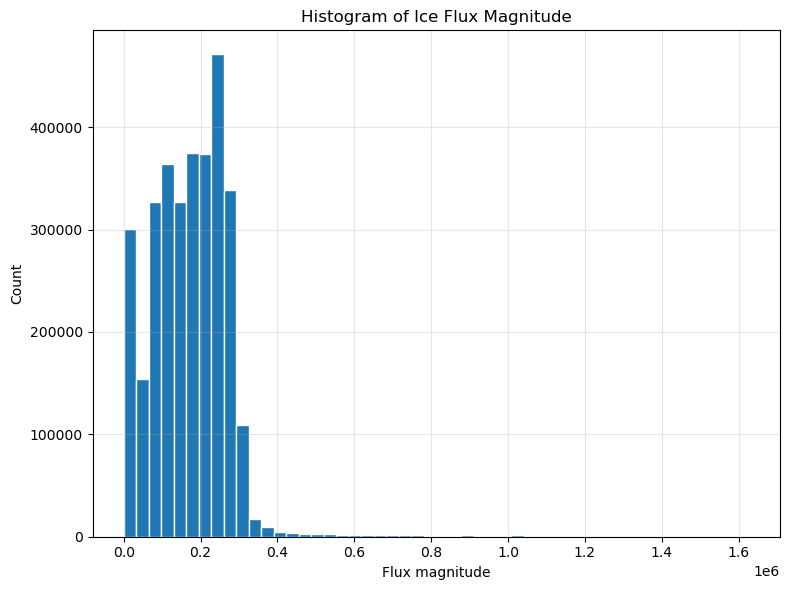

In [6]:
plt.figure(figsize = (8, 6))
plt.hist(thickness["flux_mag"], bins = 50, edgecolor="white")
plt.xlabel("Flux magnitude")
plt.ylabel("Count")
plt.title("Histogram of Ice Flux Magnitude")
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

In [7]:
# Print variance after normalisation
print(np.var(thickness["VX_flux"] / 100_000))
print(np.var(thickness["VY_flux"] / 100_000))

1.1582580433998522
0.8710024484631258


In [8]:
# Normalize into [0, 1]
thickness["x_norm"] = (thickness["x"] - x_min) / (x_max - x_min)
thickness["y_norm"] = (thickness["y"] - y_min) / (y_max - y_min)

# Build tensor with x_norm, y_norm, scaled flux
flux_tensor = torch.tensor(
    np.stack([
        thickness["x_norm"].values,
        thickness["y_norm"].values,
        thickness["VX_flux"].values / 100_000,
        thickness["VY_flux"].values / 100_000,
    ], axis = 1),
    dtype = torch.float32
)

print(flux_tensor.shape)
print(flux_tensor[:5])  # preview first rows

torch.Size([3208089, 4])
tensor([[ 0.3674,  0.2412, -0.5594, -2.4007],
        [ 0.4251,  0.2271, -0.5252, -2.4452],
        [ 0.4743,  0.2073, -0.7175, -2.8999],
        [ 0.5392,  0.2003, -0.5343, -2.9448],
        [ 0.6142,  0.2098, -0.5676, -3.2343]])


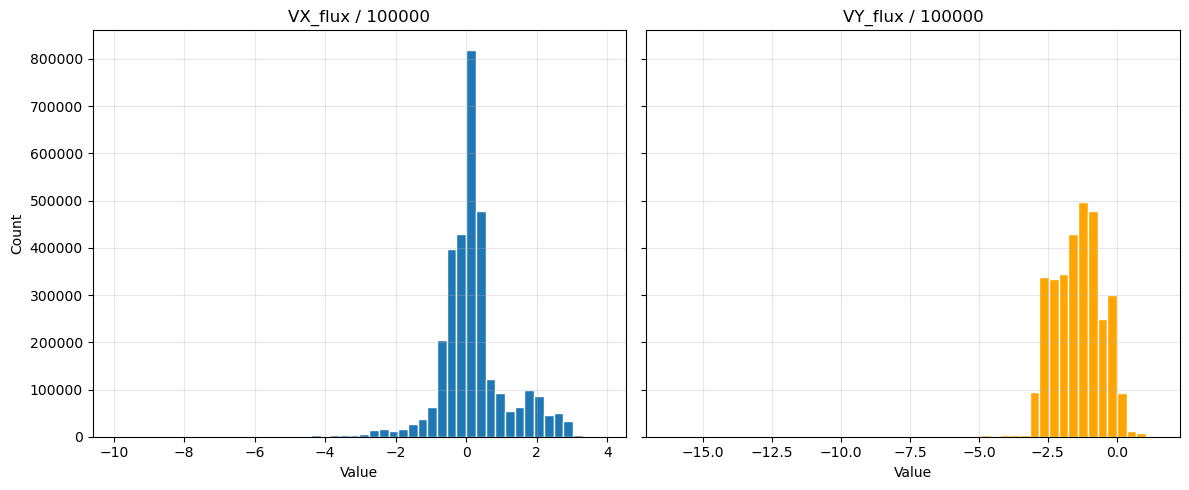

In [ ]:
import matplotlib.pyplot as plt

# Extract the last two columns
vx_flux_scaled = flux_tensor[:, 2].numpy()
vy_flux_scaled = flux_tensor[:, 3].numpy()

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize = (12, 5), sharey = True)

axes[0].hist(vx_flux_scaled, bins = 50, edgecolor = "white")
axes[0].set_title("VX_flux / 100_000")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Count")
axes[0].grid(alpha = 0.3)

axes[1].hist(vy_flux_scaled, bins = 50, edgecolor = "white", color = "orange")
axes[1].set_title("VY_flux / 100000")
axes[1].set_xlabel("Value")
axes[1].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

In [22]:
# 500 * 200
# 425 meter ice * 438 meter per year
425 * 438

186150

In [10]:
torch.save(flux_tensor, "data/flux_train_tensor.pt")